In [1]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


torch.utils.data.DataLoader is an iterator which provides all these features:

1.Batching the data

2.Shuffling the data

3.Load the data in parallel using multiprocessing workers.

Here we are using two dataloaders. One for train data and other one for test data.

In [2]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.EMNIST('/files/', train=True, download=True, split='byclass',
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.EMNIST('/files/', train=False, download=True, split='byclass',
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=64, shuffle=True)

Extracting /files/EMNIST/raw/emnist.zip to /files/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


Just looking at a sample batch from data loader

In [3]:
batch = next(iter(train_loader))
images, labels = batch
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([53, 61,  9, 47, 37,  8, 28, 30, 12,  1, 11, 45, 24, 36, 55,  1, 24,  5,
         6, 44, 23, 18, 49,  7, 29,  0, 18, 44,  1,  4,  7, 55,  9, 24, 49, 37,
        30, 42,  5, 24, 39,  6,  4, 55,  0, 36,  3, 55,  1, 55, 55,  0,  0,  7,
         4, 23,  0, 43,  8,  9,  4, 43,  6,  3])


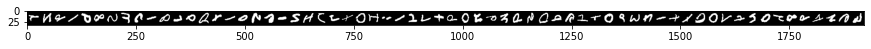

In [4]:
grid = torchvision.utils.make_grid(images, nrow=64)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

## Neural Network

In [5]:
import torch.nn.functional as F
import torch.nn as nn


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv1 block
        # Input dim (1,28,28)
        # Output dim (10,26,26)
        # RF 3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)

        # Conv2 block
        # Input dim (10,26,26)
        # Output dim (10,24,24)
        # RF 5
        
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3)

        # Conv3 block
        # Input dim (10,24,24)
        # Output dim (20,22,22)
        # RF 7
        
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)

        # Conv4 block
        # Input dim (20,11,11) Because of Max pooling size is halfed
        # Output dim (20,9,9)
        # RF 16 Because of max pooling RF is doubled (Approx)
        
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3)

        # Conv5 block
        # Input dim (20,9,9)
        # Output dim (30,7,7)
        # RF 18
        
        self.conv5 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3)

        # Conv6 block
        # Input dim (30,7,7)
        # Output dim (62,5,5)
        # RF 20
        
        self.conv6 = nn.Conv2d(in_channels=30, out_channels=62, kernel_size=3)
        self.out= nn.AvgPool2d(5)



        

    def forward(self, t):
        t = t

        t = self.conv1(t)
        t = F.relu(t)

        t = self.conv2(t)
        t = F.relu(t)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)

        t = self.conv5(t)
        t = F.relu(t)

        t = self.conv6(t)

        t = self.out(t)
        t = F.softmax(t.view(-1,62), dim=1)

        return t

We are fixing the parameters of the training like nos of epochs, learning rate, type of optimizer. Also we are using torch.device() just to check that GPU is avail or not. If yes the training will be done on GPU or else CPU.

In [6]:
import torch.optim as optim

torch.set_grad_enabled(True)

n_epochs = 25
learning_rate = 0.01
momentum = 0.5
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
network = Network().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


In [7]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

For every epoch, model will look at all the batches from dataloader. After every batch the model performs backprop and learns. So for every epoch, the model looks at the whole training data (in form of batches) and learns batch by batch. For every epoch we are calculating train error as well as test error. In test dataset we are not doing back prop. We are not learning we are just checking how good the model is able to learn.

In [10]:
for epoch in range(25):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch
        images, labels = images.to(device), labels.to(device) 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for batch in test_loader: # Get Batch
        
          images, labels = batch
          images, labels = images.to(device), labels.to(device) 

          preds = network(images) # Pass Batch
          loss = F.cross_entropy(preds, labels) # Calculate Loss

          test_loss += loss.item()
          correct += get_num_correct(preds, labels)
      print(
        "epoch", epoch, 
        "Test_correct:", correct, 
        "test_loss:", test_loss
    )



epoch 0 total_correct: 197321 loss: 42222.64475989342
epoch 0 Test_correct: 33654 test_loss: 7026.3868227005005
epoch 1 total_correct: 203162 loss: 42129.54753804207
epoch 1 Test_correct: 39581 test_loss: 6934.383509397507
epoch 2 total_correct: 239804 loss: 41559.46969294548
epoch 2 Test_correct: 42386 test_loss: 6889.964714765549
epoch 3 total_correct: 260906 loss: 41230.16518521309
epoch 3 Test_correct: 44277 test_loss: 6860.572483301163
epoch 4 total_correct: 269635 loss: 41092.42367219925
epoch 4 Test_correct: 46088 test_loss: 6831.812925338745
epoch 5 total_correct: 277976 loss: 40962.5950255394
epoch 5 Test_correct: 46678 test_loss: 6822.618691444397
epoch 6 total_correct: 282853 loss: 40886.29169178009
epoch 6 Test_correct: 47627 test_loss: 6807.948832988739
epoch 7 total_correct: 285141 loss: 40850.120033979416
epoch 7 Test_correct: 47823 test_loss: 6804.892769575119
epoch 8 total_correct: 285827 loss: 40839.85155701637
epoch 8 Test_correct: 47901 test_loss: 6803.569560289383
